## Week 9
<hr style="height: 3.0px"/>

> original version using curve_fit

**Part 3**:  `Scipy optimize()`  (week 8)  
    a. Application:  Creep Analysis of an S590 superalloy Fe-Co-Cr-Ni  
    b. Creating Larsen-Miller Plot from Creep Data (stress vs rupture time) at various temperatures  
    c. Interesting problem because instead of a typical fitting problem, here we are manipulating the set of temperature data curves with a fitting parameter that when found will collapse all the curves to one master curve (the Larsen-Miller plot).  

I'm going to look at some data from your Callister textbook and verify that the fitting parameter given in the text is correct.  

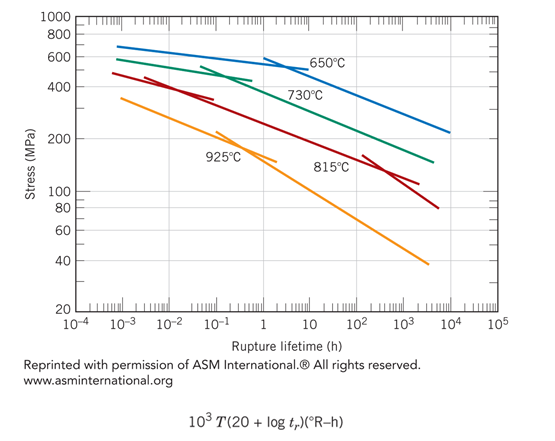  

According to the Callister textbook when you take the data in the above figure and replot as $(Log(\sigma)$ vs T (C + $Log(t_r)$) where $\sigma$ is in MPa, T is in Kelvin, $t_r$ is in hours and C is a fitting parameter which according to your textbook is 20. Here is what it looks like in your text: (Note that the x-axis in the figure below has been divided by 1000 i.e. the point 24 is really 24000.  

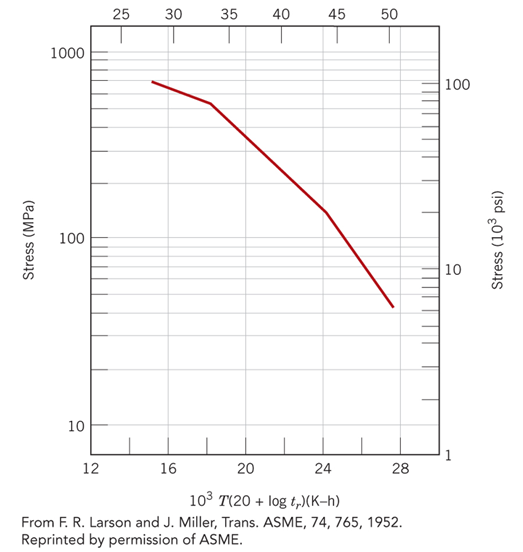  

  

First thing we need to do is select the data from the curves in our original figure.  

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import sympy as sym
from sympy import solve
from pathlib import Path


# pixel data stored in variable "pixel_positions"
# if this function throws an error stating object not an 8-bit string...
# then wrap "image_file" with str() before calling function e.g. selectdata(str(file_path))
def selectdata(image_file):
    
    #now we have 1 row and 2 columns i.e. 2 figures in a row
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(9, 4))
    # gridspec_kw={'width_ratios': [2, 2]} can be used above if needed

    # turn off the x, y axis on the image - the axis doesn't make sense for an image
    ax1.axis(False)
    
    img = mpimg.imread(image_file) #matplotlib

    image_axis = fig.add_axes([0, 0, 0.47, 0.9], zorder=10, anchor=(0.5,0.5)) #zorder places figure on top of anything else in axes
    image_axis.imshow(img)
    image_axis.axis('off')

    # recall from part 1 that image files have coord in left top corner so we need to correct by the y-dimension of the file
    ydim=img.shape[0]

    # setting title and labels for ax1 (figure on the left)
    ax1.set_title('Click on data you want to collect below')
    ax1.set_xlabel('x-pixel position')
    ax1.set_ylabel('y-pixel position')

    global pixel_positions #makes pixel_positions a global variable so we have access to it outside this function
    pixel_positions = []
    def onclick(event):
        if event.button==1:
            pixel_positions.append([event.xdata,ydim-event.ydata])
            ax2.set_title(f'Last click: [{event.xdata:.3f}, {ydim-event.ydata:.3f}]')
            ax2.scatter(event.xdata, ydim-event.ydata,marker='o', c='r', edgecolor='b') #adding scatter plot
        
#         elif event.button==3:
#             fig.canvas.mpl_disconnect(cid)
#             plt.close(fig)
    
    cid=fig.canvas.mpl_connect('button_press_event', onclick) 
    fig.show()
    
# enter list of three pixel points and list of three corresponding plot points 

# ****** changed this to take a list of three points for pixels and one for the corresponding plot calibration pts *********    
def cal(pixpts, plotpts, datatoconvert):    
    
    xpx1, ypx1 = pixpts[0]
    x1, y1 = plotpts[0]
    xpx2, ypx2 = pixpts[1]
    x2, y2 = plotpts[1]
    xpx3, ypx3 = pixpts[2]
    x3, y3 = plotpts[2]
    
    # general solution for calibration constants
    m11=(x1*ypx2 - x1*ypx3 - x2*ypx1 + x2*ypx3 + x3*ypx1 - x3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m12=-(x1*xpx2 - x1*xpx3 - x2*xpx1 + x2*xpx3 + x3*xpx1 - x3*xpx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m21=(y1*ypx2 - y1*ypx3 - y2*ypx1 + y2*ypx3 + y3*ypx1 - y3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m22=-(-xpx1*y2 + xpx1*y3 + xpx2*y1 - xpx2*y3 - xpx3*y1 + xpx3*y2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    Ox=(-x1*xpx2*y3 + x1*xpx3*y2 + x2*xpx1*y3 - x2*xpx3*y1 - x3*xpx1*y2 + x3*xpx2*y1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    Oy=(x1*y2*ypx3 - x1*y3*ypx2 - x2*y1*ypx3 + x2*y3*ypx1 + x3*y1*ypx2 - x3*y2*ypx1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    
    # define our calibrated transf matrix, m_cal, and our calibrated offset, offset_cal
    m_cal=[[m11, m12],[m21,m22]]
    offset_cal=[Ox, Oy]
    
    # return as numpy arrays
    # return(np.array(m_cal), np.array(offset_cal))
    plot_data=np.array([np.matmul(m_cal, point-offset_cal) for point in np.array(datatoconvert)])

    return(plot_data)

<IPython.core.display.Javascript object>


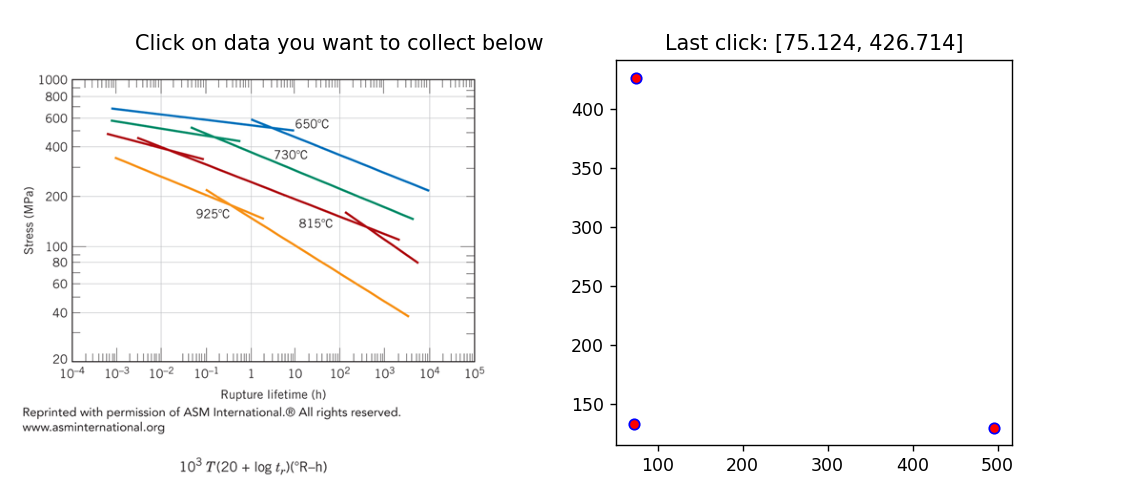

In [27]:
path=Path("C:/Users/sgc/Google Drive/Teaching/2114 & 3114 Math I & II/3114 Python/images")
filename='stress rupture from callister.png'
fullpath=path / filename
# if getting error about object not appearing to be 8-bit string path then use
# selectdata(str(fullpath))
selectdata(fullpath)

In [28]:
pixel_positions

[[496.293878974644, 130.1892710476057],
 [72.49955273350925, 132.813384522783],
 [75.12366620868656, 426.7140937426411]]

Running the above selectdata() function 5 times, I collected the following data: (Note I only selected the two end pts and any intersection points along each curve above since these were defined by straight lines.) **Also** we want the log of the data for our calibration since the axes are log and are cal() function is linear.  

In [33]:
pxpts=[[496.5562863180823, 131.23892044175602],
 [72.76196007694759, 132.55097717934467],
 [74.07401681453624, 427.76374313679145]]

logplotpts=[[5, np.log10(20)],[-4, np.log10(20)],[-4, 3]]  #Remember you need the log of the data since we have a log scale

d650C= [[448.01018702730215, 310.9906934914014],
 [282.691038091132, 376.593530370834],
 [114.74777567978445, 397.58643817225243]]
d730C=[[430.95344943864967, 282.12544526445106],
 [223.64848489964263, 367.40913320771347],
 [114.74777567978445, 384.46587079636595]]
d815C=[[436.2016763890043, 234.89140271125956],
 [382.4073501478696, 274.2531048389191],
 [172.47827213368515, 355.6006225694156],
 [110.8116054670185, 371.3453034204794]]
d925C=[[425.7052224882951, 178.47296299494747],
 [236.76905227552913, 297.8701261155149],
 [119.99600263013907, 345.10416866870634]]

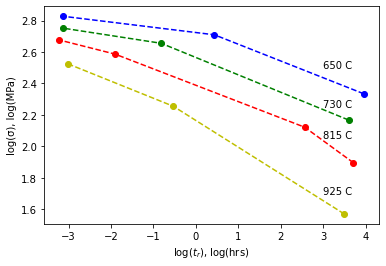

In [34]:
%matplotlib inline
cal650C=cal(pxpts, logplotpts, d650C)
cal730C=cal(pxpts, logplotpts, d730C)
cal815C=cal(pxpts, logplotpts, d815C)
cal925C=cal(pxpts, logplotpts, d925C)

plt.plot(cal650C[:,0], cal650C[:,1], 'b--', marker='o')
plt.plot(cal730C[:,0], cal730C[:,1], 'g--', marker='o')
plt.plot(cal815C[:,0], cal815C[:,1], 'r--', marker='o')
plt.plot(cal925C[:,0], cal925C[:,1], 'y--', marker='o')
plt.text(3, 2.5,'650 C')
plt.text(3, 2.25,'730 C')
plt.text(3, 2.05,'815 C')
plt.text(3, 1.7,'925 C')
plt.xlabel('log($t_r$), log(hrs)')
plt.ylabel('log(σ), log(MPa)')
plt.show()

## According to our textbook this data will collapse if C = 20

Now we want to plot log stress vs T*(20+log($t_r$))  which is known as the Larsen-Miller parameter, LM.  

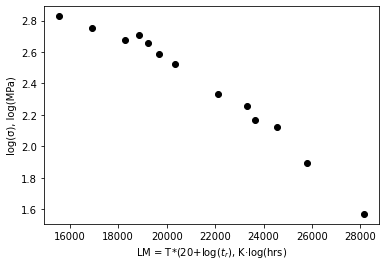

In [41]:
c_value=20

lm650C=(650+273)*(c_value+cal650C[:,0]) #calculating LM for each temperature and a C = 20
lm730C=(730+273)*(c_value+cal730C[:,0])
lm815C=(815+273)*(c_value+cal815C[:,0])
lm925C=(925+273)*(c_value+cal925C[:,0])

plt.plot(lm650C, cal650C[:,1], 'ko',marker='o')
plt.plot(lm730C, cal730C[:,1], 'ko', marker='o')
plt.plot(lm815C, cal815C[:,1], 'ko', marker='o')
plt.plot(lm925C, cal925C[:,1], 'ko', marker='o')
plt.xlabel('LM = T*(20+log($t_r$), K·log(hrs)')
plt.ylabel('log(σ), log(MPa)')
plt.show()

and magically our data collapses to one curve.  Then all we need to do is fit the data above to a polynomial function.  Well, really we want an equation for the Larsen-Miller parameter which is the x-axis as a function of log($\sigma$).  We need to flip our axes: 

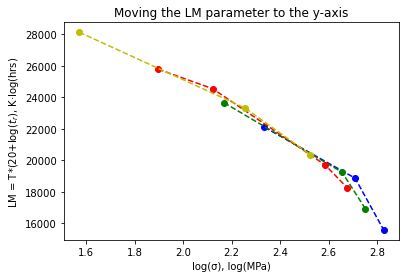

In [36]:
plt.plot(cal650C[:,1],lm650C,  'b--', marker='o')
plt.plot(cal730C[:,1],lm730C,  'g--', marker='o')
plt.plot(cal815C[:,1],lm815C,  'r--', marker='o')
plt.plot(cal925C[:,1],lm925C,  'y--', marker='o')
plt.xlabel('log(σ), log(MPa)')
plt.ylabel(f'LM = T*({c_value}+log($t_r$), K·log(hrs)')
plt.title('Moving the LM parameter to the y-axis')

plt.show()

## Fit the above data to a polynomial

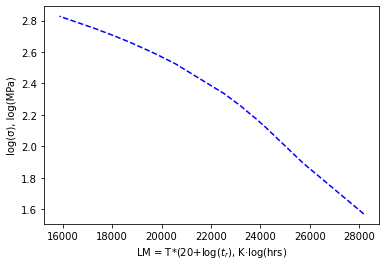

[a0, a1, a2, a3] = [81921.41759317058, -73493.26181723569, 34116.342063535856, -5795.937869448138]


In [43]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def LM(logσ, a0, a1, a2, a3):
    return(a0+a1*logσ+a2*logσ**2+a3*logσ**3)

# first put all the data together and sort by x
#x=np.append(np.append(np.append(cal650C[:,1],cal730C[:,1]),cal815C[:,1]),cal925C[:,1])
x=np.hstack((cal650C[:,1], cal730C[:,1], cal815C[:,1], cal925C[:,1]))
#y=np.append(np.append(np.append(lm650C, lm730C),lm815C),lm925C)
y=np.hstack((lm650C, lm730C, lm815C, lm925C))

temp=np.array(list(zip(x,y)))  #put all our data together as x,y pairs
temp=temp[temp[:,0].argsort()] #sort our data according to the x value, argsort() returns indices of sorted array

logσ=temp[:,0]
lmparam=temp[:,1]
      
popt, pcov = curve_fit(LM, logσ, lmparam, absolute_sigma=True)

plt.plot( LM(logσ, *popt),logσ, 'b--')
#plt.plot(lmparam,logσ,  'ro');
plt.ylabel('log(σ), log(MPa)')
plt.xlabel(f'LM = T*({c_value}+log($t_r$), K·log(hrs)')

plt.show()

print(f'[a0, a1, a2, a3] = {list(popt)}')

In [92]:
stdevs = np.sqrt(np.diag(pcov))
stdevs

array([68.38813937, 96.90362792, 44.86241215,  6.79864365])

In [82]:
popt

array([ 89994.65906663, -83611.64941097,  38791.37404638,  -6508.77716013])

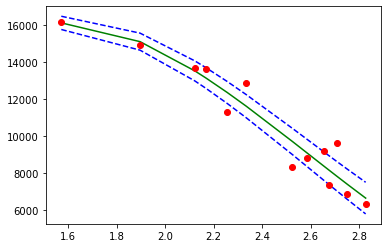

In [93]:
res = lmparam - LM(logσ, *popt)
plt.plot(logσ, LM(logσ, *(popt+stdevs)), 'b--')
plt.plot(logσ, LM(logσ, *(popt-stdevs)), 'b--')
plt.plot(logσ, LM(logσ, *(popt-0)), 'g-')
plt.plot(logσ,lmparam,  'ro');
#plt.plot(logσ, res, 'k.');

In [76]:
np.sum(res**2)

1661825.3225859685

In [77]:
np.sum((lmparam-np.mean(lmparam))**2)

162855511.28633276

In [94]:
# R^2
1-np.sum(res**2)/np.sum((lmparam-np.mean(lmparam))**2)

0.9233015516743188

**Example Problem:**

>What is the rupture lifetime at 775 C under a stress load of 355 MPa?  
We just need to calculate the LM parameter from our polynomial fit and set that equal to T*(20+log($t_r$)) and solve for the rupture time.  

In [60]:
LM(np.log10(355),81921.41759317, -73493.26181724,  34116.34206354, -5795.93786945)

20247.62533638833

20247.62533638833 = (775+273)*(20+log($t_r$))  

therefore the log($t_r$) = 20247.62533638833 /  (775+273) - 20 = -0.67974681642335  

or $t_r$ = $10^{-0.6797}$ = 0.21 hours

<hr style='height:4px' \>

## Where did this C=20 value come from.  Let's see if we can find a way to fit our data to determine C.  

First, let's look at a few C values around the value of 20 and see what the data looks like.  You can see below the goodness of fit to a polynomial for various C values.  The routine below will vary this C parameter until the optimal fit is achieved.  In this case it looks like a C of 20.789 is best.  
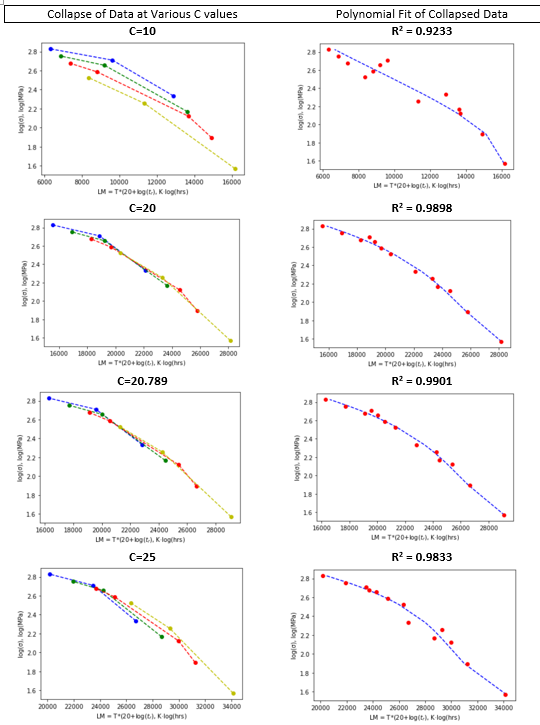

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

def func(x, b0, b1, b2, b3):
    return b0+b1*x+b2*x**2+b3*x**3

def cost(c, cal650C, cal730C, cal815C, cal925C):
    
    global popt, logσ, lmparam
    
    lm650C=(650+273)*(c+cal650C[:,0]) #calculate lm param with an initial guess of "c"
    lm730C=(730+273)*(c+cal730C[:,0])
    lm815C=(815+273)*(c+cal815C[:,0])
    lm925C=(925+273)*(c+cal925C[:,0])
    
    #appending all our data together
    x=np.append(np.append(np.append(cal650C[:,1],cal730C[:,1]),cal815C[:,1]),cal925C[:,1])
    y=np.append(np.append(np.append(lm650C, lm730C),lm815C),lm925C)
    #placing our data as x,y pairs using the function zip
    #then sorting so the x values are in order 
    temp=np.array(list(zip(x,y)))  #put all our data together as x,y pairs
    temp=temp[temp[:,0].argsort()] #sort our data according to the x value
    
    #here's now the data we will fit
    logσ=temp[:,0] #the x data is actually the log of stress
    lmparam=temp[:,1] #the y data is the larsen miller value calculated above
    
    popt, pcov = curve_fit(func, logσ, lmparam) #fit our data to a polynomial
    
    #the next few step determine the error between the fit and the data
    #as the data collapses together by changing "c" the error should get smaller
    #we return the error as 1-Rsquared
    residuals = lmparam - func(logσ, *popt) #calculate the difference between the fit and the data
    ss_res = np.sum(residuals**2) #calculate the sum of the squares
    ss_tot = np.sum((lmparam-np.mean(lmparam))**2) #calculate the sum of the squares relative to the mean value
    r_squared = 1 - (ss_res / ss_tot) # now find the Rsquared value for the fit
   
    return 1-r_squared #return 1-Rsquared - this is what should be minimized on a good fit

#now call the function cost() with an initial guess of 1.0 for "c" and continue to call the function 
#changing "c" until 1-Rsquared is minimized.  The minimize function takes care of this for us. 
result = optimize.minimize(cost, 1.0, args=(cal650C, cal730C, cal815C, cal925C))

print(f'C: {result.x[0]:3.3f}')
print(popt)

NameError: name 'cal650C' is not defined

In [34]:
popt

array([ 89989.58715474, -83605.27912244,  38788.43172942,  -6508.32873751])

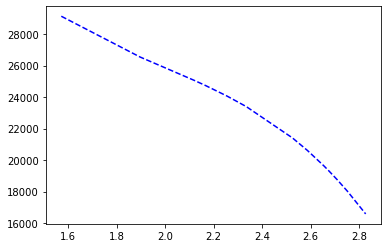

In [36]:
plt.plot(logσ, func(logσ, popt[0], popt[1], popt[2],popt[3]), 'b--')

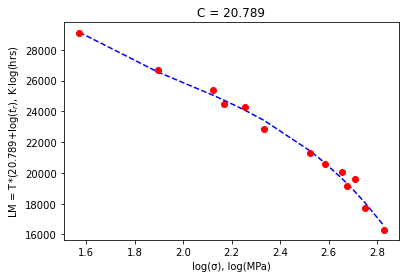

In [35]:
plt.plot(logσ, func(logσ, *popt), 'b--')
plt.plot(logσ, lmparam, 'ro');
plt.xlabel('log(σ), log(MPa)')
plt.ylabel(f'LM = T*({result.x[0]:3.3f}+log($t_r$), K·log(hrs)')
plt.title(f'C = {result.x[0]:3.3f}')
plt.show()

You can see that we got a C value of 20.789 which is better than the value of 20 used by the textbook - although the difference is minor.  

Let's look at that example problem again: 

>What is the rupture lifetime at 775 C under a stress load of 355 MPa?  
We just need to calculate the LM parameter from our polynomial fit and set that equal to T*(20.789+log($t_r$)) and solve for the rupture time. 

In [94]:
LM(np.log10(355),89989.58715474, -83605.27912244,  38788.43172942,  -6508.32873751)

21097.95224555531

21097.95224555531 = (775+273)*(20.789+log($t_r$))  

therefore the log($t_r$) = 21097.95224555531 /  (775+273) - 20.789 = -0.6573661779052422  

or $t_r$ = $10^{-0.65736617790524227}$ = 0.22 hours (only about 36 seconds different from our last answer )

## Your turn :)

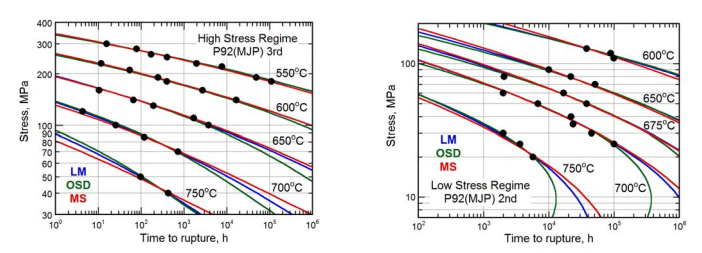

#### To do:   

1. Pick either the High Stress Regime (fig a) or the Low Stress Regime (fig b) or you can do both!  Use selectdata() and cal() to grab all of the data points on the figure you chose and replot the figure.  Remember to be careful with the log axes when you find plotpts.  

2. Collapse all your data to one curve on a Larsen-Miller plot by finding the factor "C".  This is not trial and error.  Use a fitting routine to find "C".  

3. Switch your x & y axes from step 2 and replot.  Now fit this data to a polynomial and replot the data including your fit.  Print out the final polynomial values of your fit.      

<IPython.core.display.Javascript object>


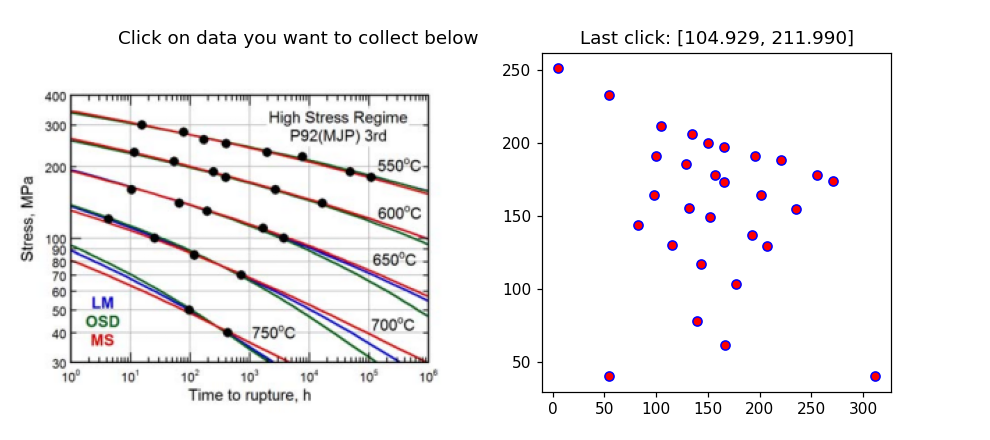

In [4]:
path=Path("C:/Users/sgc/Google Drive/Teaching/2114 & 3114 Math I & II/3114 Python/images")
filename='stress rupture data.png'
fullpath=path / filename
# if getting error about object not appearing to be 8-bit string path then use
# selectdata(str(fullpath))
selectdata(fullpath)

In [2]:
logplotpts=[[6, np.log10(30)],[0, np.log10(30)],[0, np.log10(400)]]
pxpts=[[311.5894987415113, 40.096721198939974],
 [54.25381149224674, 40.096721198939974],
 [54.25381149224674, 233.2964371645416]]
d750C=[ [166.68971176731003, 61.54736250063024],
 [139.76843987046388, 78.17520690750581]]
d700C=[[176.9831392572806, 103.5128745751257],
 [142.9356483289164, 116.97351052354875],
 [115.2225743174571, 130.43414647197181],
 [81.966885503706, 143.89478242039488]]
d650C=[[207.07161961257924, 129.6423443573587],
 [192.81918154954303, 136.76856338887677],
 [151.64547158966073, 149.4373972226867],
 [131.85041872433266, 155.7718141395917],
 [97.80292779596843, 164.48163740033604]]
d600C=[[234.78469362403848, 154.98001202497858],
 [201.52900481028738, 164.48163740033604],
 [165.8979096526969, 173.19146066108036],
 [156.39628427733945, 177.9422733487591],
 [128.68321026588018, 185.8602944948903],
 [100.1783341398078, 191.40290929718216]]
d550C=[[270.415788781629, 173.98326277569348],
 [255.37154860397965, 177.9422733487591],
 [220.5322555610023, 188.23570083872968],
 [195.19458789338242, 191.40290929718216],
 [165.8979096526969, 197.73732621408712],
 [150.06186736043446, 200.11273255792648],
 [135.01762718278516, 206.44714947483146],
 [104.92914682748652, 211.9897642771233]]

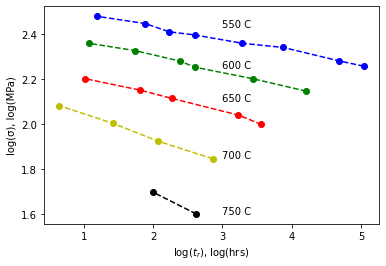

In [3]:
%matplotlib inline
cal550C=cal(pxpts, logplotpts, d550C)
cal600C=cal(pxpts, logplotpts, d600C)
cal650C=cal(pxpts, logplotpts, d650C)
cal700C=cal(pxpts, logplotpts, d700C)
cal750C=cal(pxpts, logplotpts, d750C)

plt.plot(cal550C[:,0], cal550C[:,1], 'b--', marker='o')
plt.plot(cal600C[:,0], cal600C[:,1], 'g--', marker='o')
plt.plot(cal650C[:,0], cal650C[:,1], 'r--', marker='o')
plt.plot(cal700C[:,0], cal700C[:,1], 'y--', marker='o')
plt.plot(cal750C[:,0], cal750C[:,1], 'k--', marker='o')
plt.text(3, 2.43,'550 C')
plt.text(3, 2.25,'600 C')
plt.text(3, 2.1,'650 C')
plt.text(3, 1.85,'700 C')
plt.text(3, 1.6,'750 C')
plt.xlabel('log($t_r$), log(hrs)')
plt.ylabel('log(σ), log(MPa)')
plt.show()

In [4]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

def LM(x, b0, b1, b2, b3):
    return b0+b1*x+b2*x**2+b3*x**3

def cost(c, cal550C, cal600C, cal650C, cal700C, cal750C):
    
    global popt, logσ, lmparam
    
    lm550C=(550+273)*(c+cal550C[:,0]) #calculate lm param with an initial guess of "c"
    lm600C=(600+273)*(c+cal600C[:,0])
    lm650C=(650+273)*(c+cal650C[:,0])
    lm700C=(700+273)*(c+cal700C[:,0])
    lm750C=(750+273)*(c+cal750C[:,0])
    
    #appending all our data together
    x=np.hstack((cal550C[:,1],cal600C[:,1],cal650C[:,1],cal700C[:,1],cal750C[:,1]))
    y=np.hstack((lm550C,lm600C,lm650C,lm700C,lm750C))
    
    #placing our data as x,y pairs using the function zip
    #then sorting so the x values are in order 
    temp=np.array(list(zip(x,y)))  #put all our data together as x,y pairs
    temp=temp[temp[:,0].argsort()] #sort our data according to the x value
    
    #here's now the data we will fit
    logσ=temp[:,0] #the x data is actually the log of stress
    lmparam=temp[:,1] #the y data is the larsen miller value calculated above
    
    popt, pcov = curve_fit(LM, logσ, lmparam) #fit our data to a polynomial
    
    #the next few step determine the error between the fit and the data
    #as the data collapses together by changing "c" the error should get smaller
    #we return the error as 1-Rsquared
    residuals = lmparam - LM(logσ, *popt) #calculate the difference between the fit and the data
    ss_res = np.sum(residuals**2) #calculate the sum of the squares
    ss_tot = np.sum((lmparam-np.mean(lmparam))**2) #calculate the sum of the squares relative to the mean value
    r_squared = 1 - (ss_res / ss_tot) # now find the Rsquared value for the fit
   
    return 1-r_squared #return 1-Rsquared - this is what should be minimized on a good fit

#now call the function cost() with an initial guess of 1.0 for "c" and continue to call the function 
#changing "c" until 1-Rsquared is minimized.  The minimize function takes care of this for us. 
result = optimize.minimize(cost, 1.0, args=(cal550C,cal600C,cal650C,cal700C,cal750C))

print(f'C: {result.x[0]:3.3f}')
print(popt)

C: 37.889
[ 54639.81179654 -15752.32104477   8354.62544176  -2286.31734912]


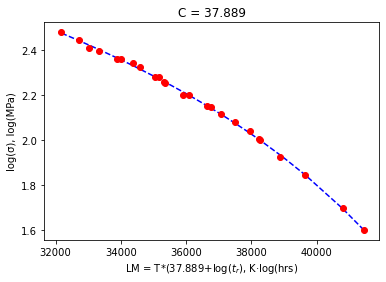

In [5]:
plt.plot(LM(logσ,  *popt), logσ, 'b--')
plt.plot(lmparam, logσ, 'ro');
plt.ylabel('log(σ), log(MPa)')
plt.xlabel(f'LM = T*({result.x[0]:3.3f}+log($t_r$), K·log(hrs)')
plt.title(f'C = {result.x[0]:3.3f}')
plt.show()

In [16]:
σ

array([  10.        ,   13.89495494,   19.30697729,   26.82695795,
         37.2759372 ,   51.79474679,   71.9685673 ,  100.        ,
        138.94954944,  193.06977289,  268.26957953,  372.75937203,
        517.94746792,  719.685673  , 1000.        ])

In [24]:
lσ=np.linspace(1,3,15)
σ=10**lσ
datalog=np.array(list(zip(LM(lσ,  *popt), lσ)))
datalin=np.array(list(zip(LM(lσ,  *popt), σ)))

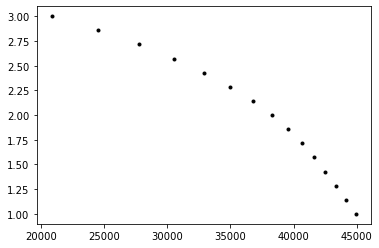

In [25]:
plt.plot(datalog[:,0],datalog[:,1], 'k.');

In [54]:
print(f'{datalin}')

[[4.49557988e+04 1.00000000e+01]
 [4.41365111e+04 1.38949549e+01]
 [4.33382774e+04 1.93069773e+01]
 [4.25211038e+04 2.68269580e+01]
 [4.16449964e+04 3.72759372e+01]
 [4.06699613e+04 5.17947468e+01]
 [3.95560047e+04 7.19685673e+01]
 [3.82631327e+04 1.00000000e+02]
 [3.67513513e+04 1.38949549e+02]
 [3.49806667e+04 1.93069773e+02]
 [3.29110850e+04 2.68269580e+02]
 [3.05026123e+04 3.72759372e+02]
 [2.77152547e+04 5.17947468e+02]
 [2.45090183e+04 7.19685673e+02]
 [2.08439092e+04 1.00000000e+03]]


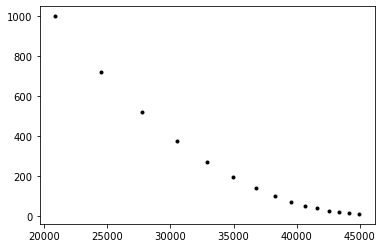

In [26]:
plt.plot(datalin[:,0],datalin[:,1], 'k.');

In [27]:
10**1.25

17.78279410038923

In [30]:
np.log10(80)

1.9030899869919435